# Logistic Regression

### Assumptions of Logistic Regression

1. **Binary Outcome Variable**: The dependent variable in logistic regression is binary, meaning it has only two possible outcomes (e.g., success/failure, yes/no).

2. **Independence**: The observations are independent of each other. This means that the outcome for one observation does not affect the outcome for another observation.

3. **Linearity of Logit**: There is a linear relationship between the logit (the natural log of the odds) of the outcome and each predictor variable. This means that the predictors are linearly related to the log-odds of the dependent variable.

4. **No Perfect Multicollinearity**: The independent variables are not perfectly collinear, which means there is no exact linear relationship among the predictors. High multicollinearity can make it difficult to determine the individual effect of each predictor.

5. **Large Sample Size**: Logistic regression requires a large sample size to ensure that the maximum likelihood estimation procedure is reliable and the results are stable.

6. **Appropriate Link Function**: Logistic regression uses the logit link function, which is appropriate for modeling a binary outcome.

7. **Absence of Influential Outliers**: The model should not be unduly influenced by extreme values or outliers in the predictors, as they can disproportionately affect the model's estimates.

Log Loss = -1/N * sum(ylog(p) + (1-y)log(1-p))

Minimize using Gradient Decent

The log loss was not just pulled out of a hat. It can be shown mathematically (using
Bayesian inference) that minimizing this loss will result in the model with the maximum
likelihood of being optimal, assuming that the instances follow a Gaussian distribution
around the mean of their class. When you use the log loss, this is the implicit assumption
you are making. The more wrong this assumption is, the more biased the model will be.
Similarly, when we used the MSE to train linear regression models, we were implicitly
assuming that the data was purely linear, plus some Gaussian noise. So, if the data is not
linear (e.g., if it’s quadratic) or if the noise is not Gaussian (e.g., if outliers are not exponentially rare), then the model will be biased.

In [1]:
import sys
from pathlib import Path

# Adjust the path based on the location of your notebook
sys.path.append(str(Path().resolve().parent))

# Second cell: Import the PATH from settings
from linear_regression.settings import PATH

print(PATH)

C:\Dev\MachineLearningGroup


Logistic regression in Sklearn and Statsmodels are different. By default Sklearn does regularization, and Statsmodels does not. This is very important to know when applying LR in practice using Sklearn/Statsmodels. 

The hyperparameter controlling the regularization strength of a Scikit-Learn
LogisticRegression model is not alpha (as in other linear models), but its inverse: C. The
higher the value of C, the less the model is regularized. Scikit-Learn actually adds an L2 penalty
by default.

In [9]:
# Importing packages to develop the model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from scipy import stats
# import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler)
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In this lab we will examine the Smarket data, which is part of the ISLP library. This data set consists of percentage returns for the S&P 500 stock index over 1,250 days, from the beginning of 2001 until the end of 2005. For each date, we have recorded the percentage returns for each of the five previous trading days, Lag1 through Lag5. We have also recorded Volume (the number of shares traded on the previous day, in billions), Today (the percentage return on the date in question) and Direction (whether the market was Up or Down on this date).

In [3]:
dir_data = PATH / Path('data')
input_file = 'Smarket.csv'
file_path_data = dir_data / Path(input_file)

df = pd.read_csv(file_path_data)
df

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


In [4]:
df.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


As one would expect, the correlations between the lagged return variables and today’s return are close to zero. The only substantial correlation is between Year and Volume. By plotting the data we see that Volume is increasing over time. In other words, the average number of shares traded daily increased from 2001 to 2005.

<Axes: >

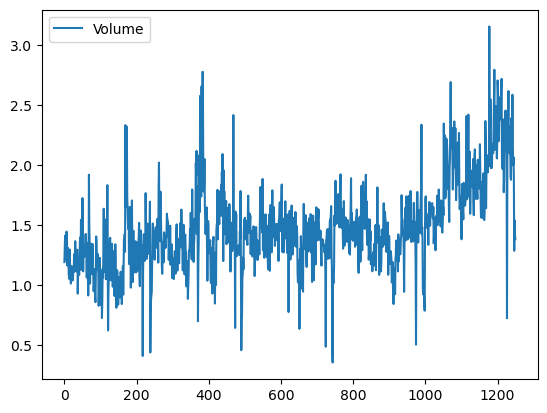

In [5]:
df.plot(y='Volume')

In [6]:
df.dtypes

Year           int64
Lag1         float64
Lag2         float64
Lag3         float64
Lag4         float64
Lag5         float64
Volume       float64
Today        float64
Direction     object
dtype: object

Next, we will fit a logistic regression model in order to predict Direction using Lag1 through Lag5 and Volume. The sm.GLM() function fits generalized linear models, a class of models that includes logistic regression. sm.GLM() generalized Alternatively, the function sm.Logit() fits a logistic regression model directly. The syntax of sm.GLM() is similar to that of sm.OLS(), except that we must pass in the argument family=sm.families.Binomial() in order to tell statsmodels to run a logistic regression rather than some other type of generalized linear model.

Label encode such that 1 = Up (what we want to predict) and 0 = Down.

In [7]:
# Import label encoder 
from sklearn import preprocessing 
  
# label_encoder object knows  
# how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
df['Direction']= label_encoder.fit_transform(df['Direction']) 
  
df['Direction'].unique() 

array([1, 0])

In [ ]:
#Sklearn
#By default scikit-learn uses an l2 regularization penalty, which we don't want for vanilla logistic regression as described in the book:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(penalty = "none", solver = "lbfgs")
log_reg.fit(X, y)
params = np.concatenate((log_reg.intercept_, log_reg.coef_.flatten()))
pd.DataFrame(data = {"Coef. Est.":params}, index = X.columns.insert(0, "intercept"))

In [8]:
X = df.drop(columns=['Today', 'Direction', 'Year'])
y = df.Direction == 1 # endog = (df["Direction"] == "Up").astype("int64")
X = sm.add_constant(X)
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1250
Model:                            GLM   Df Residuals:                     1243
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -863.79
Date:                Thu, 23 May 2024   Deviance:                       1727.6
Time:                        19:36:05   Pearson chi2:                 1.25e+03
No. Iterations:                     4   Pseudo R-squ. (CS):           0.002868
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

The smallest p-value here is associated with Lag1. The negative coefficient for this predictor suggests that if the market had a positive return yesterday, then it is less likely to go up today. However, at a value of 0.15, the p-value is still relatively large, and so there is no clear evidence of a real association between Lag1 and Direction.

The predict() method of results can be used to predict the probability that the market will go up, given values of the predictors. This method returns predictions on the probability scale. If no data set is supplied to the predict() function, then the probabilities are computed for the training data that was used to fit the logistic regression model. As with linear regression, one can pass an optional exog argument consistent with a design matrix if desired. Here we have printed only the first ten probabilities.

In [24]:
y.value_counts()

Direction
True     648
False    602
Name: count, dtype: int64

In [9]:
probs = results.predict()
probs[:10]

array([0.50708413, 0.48146788, 0.48113883, 0.51522236, 0.51078116,
       0.50695646, 0.49265087, 0.50922916, 0.51761353, 0.48883778])

In [27]:
results.fittedvalues

0       0.507084
1       0.481468
2       0.481139
3       0.515222
4       0.510781
          ...   
1245    0.519892
1246    0.505926
1247    0.539268
1248    0.526118
1249    0.517917
Length: 1250, dtype: float64

In order to make a prediction as to whether the market will go up or down on a particular day, we must convert these predicted probabilities into class labels, Up or Down. The following two commands create a vector of class predictions based on whether the predicted probability of a market increase is greater than or less than 0.5.

In [17]:
labels = np.array([0]*1250)
labels[probs > 0.5] = 1

In [18]:
labels

array([1, 0, 0, ..., 1, 1, 1])

The confusion_table() function from the ISLP package summarizes these confusion_predictions, showing how many observations were correctly or incorrectly table() classified. Our function, which is adapted from a similar function in the module sklearn.metrics, transposes the resulting matrix and includes row and column labels. The confusion_table() function takes as first argument the predicted labels, and second argument the true labels.

In [19]:
np.array(df.Direction)

array([1, 1, 0, ..., 1, 0, 0])

In [20]:
metrics.confusion_matrix(labels , df.Direction)

array([[145, 141],
       [457, 507]], dtype=int64)

The diagonal elements of the confusion matrix indicate correct predictions, while the off-diagonals represent incorrect predictions. Hence our model correctly predicted that the market would go up on 507 days and that it would go down on 145 days, for a total of 507 + 145 = 652 correct
predictions. The np.mean() function can be used to compute the fraction of days for which the prediction was correct. In this case, logistic regression correctly predicted the movement of the market 52.2% of the time.

In [21]:
(507+145)/1250, np.mean(labels == df.Direction)

(0.5216, 0.5216)

In [22]:
metrics.roc_auc_score(labels , df.Direction)

0.5164633084757566

In [53]:
gini = (2 * metrics.roc_auc_score(labels , df.Direction)) - 1
gini

0.03292661695151322

Assumption testing:
https://github.com/kennethleungty/Logistic-Regression-Assumptions/blob/main/Logistic_Regression_Assumptions.ipynb

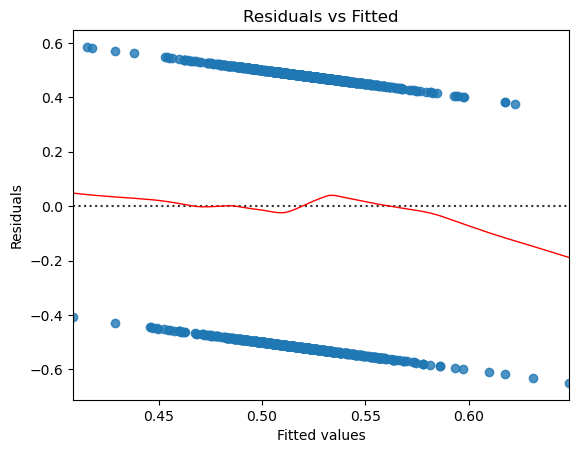

In [31]:
# Fitted values
model1_fitted_y = results.fittedvalues

# Normalized residuals
model1_norm_residuals = results.get_influence().resid_studentized

# Absolute squared normalized residuals
model1_norm_residuals_abs_sqrt = np.sqrt(np.abs(model1_norm_residuals))

# Leverage, from statsmodels internals
model1_leverage = results.get_influence().hat_matrix_diag

# Plot 1: residuals vs. fitted values
plot1 = plt.figure(1)
sns.residplot(x=model1_fitted_y, y=y, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.show()

Text(0.5, 0, 'Fitted values')

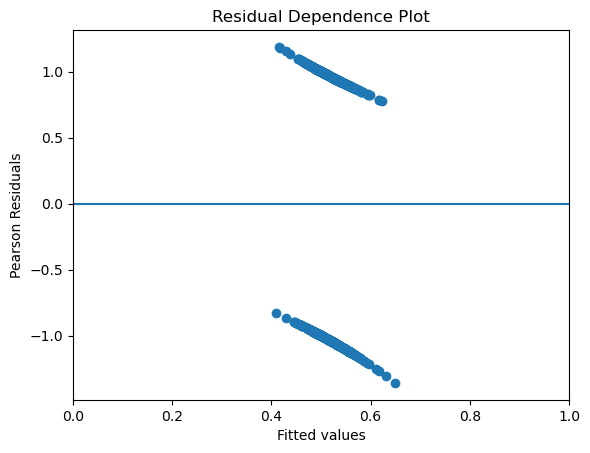

In [32]:
fig, ax = plt.subplots()

ax.scatter(results.fittedvalues, results.resid_pearson)
ax.hlines(0, 0, 1)
ax.set_xlim(0, 1)
ax.set_title('Residual Dependence Plot')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

Text(0.5, 1.0, 'Histogram of standardized deviance residuals')

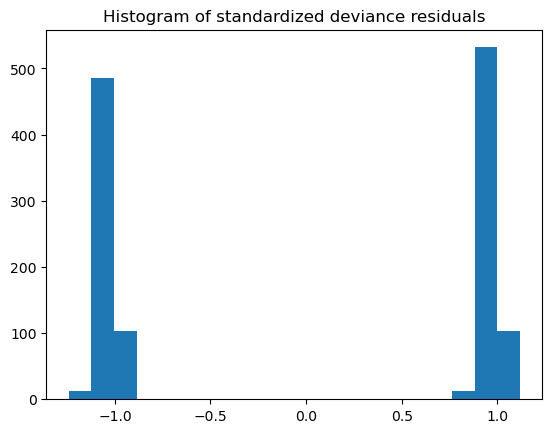

In [33]:
from scipy import stats

fig, ax = plt.subplots()

resid = results.resid_deviance.copy()
resid_std = stats.zscore(resid)
ax.hist(resid_std, bins=20)
ax.set_title('Histogram of standardized deviance residuals')

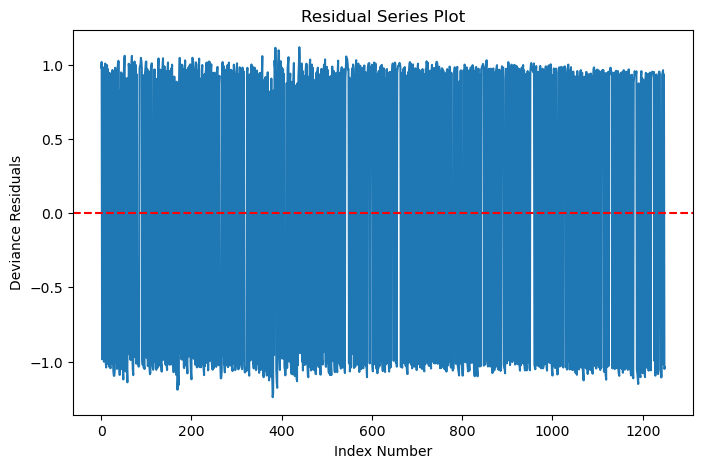

In [34]:
# Generate residual series plot
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
                    xlabel="Index Number", ylabel="Deviance Residuals")

ax.plot(X.index.tolist(), stats.zscore(results.resid_deviance))
plt.axhline(y=0, ls="--", color='red')

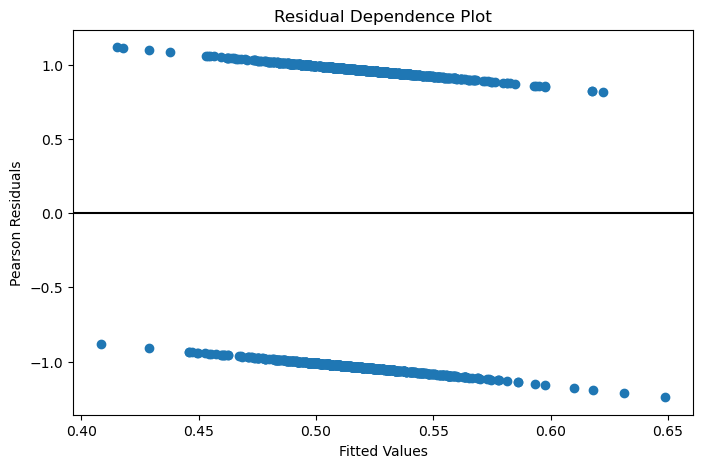

In [35]:
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(
            111,
            title="Residual Dependence Plot",
            xlabel="Fitted Values",
            ylabel="Pearson Residuals")

# ax.scatter(logit_results.mu, stats.zscore(logit_results.resid_pearson))
ax.scatter(results.mu, stats.zscore(results.resid_deviance))
ax.axis("tight")
ax.plot([0.0, 1.0], [0.0, 0.0], "k-");

https://github.com/kennethleungty/Logistic-Regression-Assumptions/blob/main/Logistic_Regression_Assumptions.ipynb

In [36]:
# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [VIF(df.values, i) for i in range(df.shape[1])]
    return(vif)

calc_vif(X) # Include constant in VIF calculation in Python

,variables,VIF
0,const,17.986525
1,Lag1,1.002406
2,Lag2,1.003498
3,Lag3,1.003757
4,Lag4,1.004058
5,Lag5,1.001757
6,Volume,1.008405


The threshold for VIF is usually 5 (i.e. values above 5 means there is presence of multicollinearity).

In [37]:
from scipy import stats

# Get influence measures
influence = results.get_influence()

# Obtain summary df of influence measures
summ_df = influence.summary_frame()

# Filter summary df to Cook distance
diagnosis_df = summ_df.loc[:,['cooks_d']]

# Append absolute standardized residual values
diagnosis_df['std_resid'] = stats.zscore(results.resid_pearson)
diagnosis_df['std_resid'] = diagnosis_df.loc[:,'std_resid'].apply(lambda x: np.abs(x))

# Sort by Cook's Distance
diagnosis_df.sort_values("cooks_d", ascending=False)
diagnosis_df

,cooks_d,std_resid
0,0.003107,0.985947
1,0.001078,1.037792
2,0.000862,0.962881
3,0.000346,0.970022
4,0.000417,0.978682
...,...,...
1245,0.000292,0.960994
1246,0.000203,1.011838
1247,0.000192,0.924337
1248,0.000247,1.053590


In [38]:
# Set Cook's distance threshold
cook_threshold = 4 / len(X)
print(f"Threshold for Cook Distance = {cook_threshold}")

Threshold for Cook Distance = 0.0032


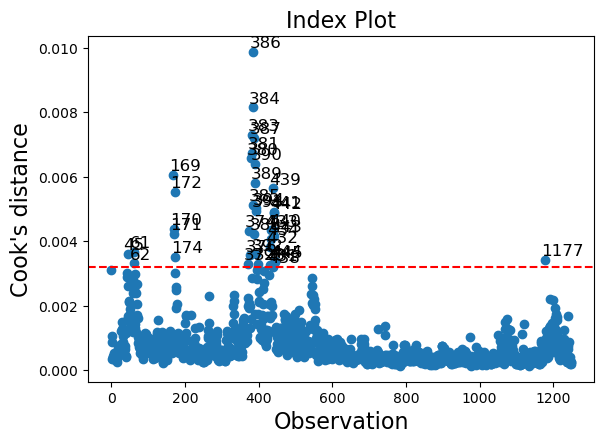

In [39]:
# Plot influence measures (Cook's distance)
fig = influence.plot_index(y_var="cooks", threshold=cook_threshold)
plt.axhline(y=cook_threshold, ls="--", color='red')
fig.tight_layout(pad=2)

In [40]:
# Find number of observations that exceed Cook's distance threshold
outliers = diagnosis_df[diagnosis_df['cooks_d'] > cook_threshold]
prop_outliers = round(100*(len(outliers) / len(X)),1)
print(f'Proportion of data points that are highly influential = {prop_outliers}%')

Proportion of data points that are highly influential = 3.0%


In [41]:
# Find number of observations which are BOTH outlier (std dev > 3) and highly influential
extreme = diagnosis_df[(diagnosis_df['cooks_d'] > cook_threshold) & 
                       (diagnosis_df['std_resid'] > 3)]
prop_extreme = round(100*(len(extreme) / len(X)),1)
print(f'Proportion of highly influential outliers = {prop_extreme}%')

Proportion of highly influential outliers = 0.0%


In [43]:
# Display top 5 most influential outliers
outliers.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid
386,0.009886,1.180665
384,0.008156,1.050904
383,0.007303,0.925370
387,0.007205,1.033529
381,0.006737,1.308199


In [42]:
# Display top 5 most influential outliers
extreme.sort_values("cooks_d", ascending=False).head()

,cooks_d,std_resid


In [44]:
# Deep dive into index 297 (extreme outlier)
X.iloc[386]

const     1.00000
Lag1      5.40800
Lag2      1.68800
Lag3     -0.56300
Lag4      5.73300
Lag5     -2.70200
Volume    1.77865
Name: 386, dtype: float64

In [45]:
y.iloc[386] 

True

It is important to note that for data points with relative high Cook's distances, it does not automatically mean that it should be immediately removed from the dataset. It is essentially an indicator to highlight which data points are worth looking deeper into, to understand whether they are true anomalies or not. In practice, an assessment of “large” values is a judgement call based on experience and the particular set of data being analyzed. In addition, based on our pre-defined threshold (4/N), only 3% of the points are in the outlier zone, which is small as well. The issue comes when there is a significant number of data points classified as outliers.

Assumption - Linearity of independent variables and log odds
One of the important assumptions of logistic regression is the linearity of the logit over the continuous covariates. This assumption means that relationships between the continuous predictors and the logit (log odds) is linear. The Box-Tidwell transformation (test) can be used to test the linearity in the logit assumption when performing logistic regression. It checks whether the logit transform is a linear function of the predictor, effectively adding the non-linear transform of the original predictor as an interaction term to test if this addition made no better prediction. A statistically significant p-value of the interaction term in the Box-Tidwell transformation means that the linearity assumption is violated. If one variable is indeed found to be non-linear, then we can resolve it by incorporating higher order polynomial terms for that variable in the regression analysis to capture the non-linearity (e.g. x^2). Another solution to this problem is the categorization of the independent variables. That is transforming metric variables to ordinal level and then including them in the model.

There is no native Python package to run the Box Tidwell test (unlike in R), so we will have to implement this manually.

# ISLR Applied EXERCISE 4.10

In [3]:
dir_data = PATH / Path('data')
input_file = 'Boston.csv'
file_path_data = dir_data / Path(input_file)

df = pd.read_csv(file_path_data)
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [4]:
df['crim01'] = np.where(df['crim'] > df['crim'].median(), 1, 0)

In [5]:
df['crim01']

0      0
1      0
2      0
3      0
4      0
      ..
501    0
502    0
503    0
504    0
505    0
Name: crim01, Length: 506, dtype: int32

In [6]:
columns_of_interest = ['indus', 'nox', 'dis', 'tax', 'lstat']
X = pd.DataFrame(df, columns=columns_of_interest)
y = np.array(df['crim01'])

In [10]:
glm = LogisticRegression()
glm.pred = glm.fit(X, y).predict(X)

In [11]:
pd.DataFrame(metrics.confusion_matrix(y, glm.pred), index=['y=0', 'y=1'], columns=['y_pred=0', 'y_pred=1'])

,y_pred=0,y_pred=1
y=0,219,34
y=1,60,193


In [12]:
print('error rate: ', 1-metrics.accuracy_score(y, glm.pred))

error rate:  0.18577075098814233


# Additonal Examples

https://towardsdatascience.com/all-the-annoying-assumptions-31b55df246c3

https://towardsdatascience.com/assumptions-of-logistic-regression-clearly-explained-44d85a22b290

https://mlu-explain.github.io/logistic-regression/

https://medium.com/@curryrowan/simplified-logistic-regression-classification-with-categorical-variables-in-python-1ce50c4b137

https://towardsdatascience.com/hypothesis-testing-explained-how-i-wish-it-was-explained-to-me-14379f7a41c3

https://towardsdatascience.com/which-features-are-harmful-for-your-classification-model-6227859a44a6

https://medium.com/@kstarun/model-evaluation-metrics-gini-coefficient-db919ed09306

https://towardsdatascience.com/using-the-gini-coefficient-to-evaluate-the-performance-of-credit-score-models-59fe13ef420

https://towardsdatascience.com/how-to-effectively-predict-imbalanced-classes-in-python-e8cd3b5720c4

https://python.plainenglish.io/a-practical-catalog-to-model-evaluation-metrics-for-machine-learning-74eafeb751a0

https://towardsdatascience.com/model-selection-with-imbalance-data-only-auc-may-not-save-you-5aed73c5efed

https://dsdojo.medium.com/the-only-performance-metrics-article-you-will-ever-need-135cf5e693e2

https://nikhilkumawat106.medium.com/accuracy-precision-recall-and-f1-score-visualise-cbb77f330346

https://medium.com/@data.science.enthusiast/how-to-improve-logistic-regression-in-imbalanced-data-with-class-weights-1693719136aa

https://towardsdatascience.com/you-deserve-a-better-roc-curve-970617528ce8

https://medium.com/geekculture/logistic-regression-using-gradient-descent-intuition-and-implementation-36a8498afdcb